# COMP47590: Advanced Machine Learning
# Assignment 1: The Super Learner

## Import Packages Etc

In [1]:
import time
ticks = time.time()

In [2]:
import os
import subprocess
from IPython.display import display, HTML, Image
import io
from operator import itemgetter

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
from scipy.misc import toimage

from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import neural_network
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.model_selection import KFold
import ipdb
import copy
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

In [3]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer and a aggregatnio model at the aggregation layer. A k-fold cross validation is used to gnerate training data for the stack layer model.

    Parameters
    ----------
    v_fold - number of folds used to generate input for stack layer default is 5
    baseClfList - list which contains models used for base estimators
    multiplyBaseClf - multiplication factor for base estimators to genearate ensemble default is one
    stackLayerClf - type of model used for stack layer default is Tree
    use_base_prob - use of Probablity outputs of base classifier when it is true
    add_ip_features_stackLayer = False
        
    Attributes
    ----------
    No attributes


    Notes
    -----
    Super Learner algorithm which takes fixed set of 6 base models from scikit-learn 
    (e.g. decision trees, logistic regression, or neural networks models). 
    It is ensemble approach with heterogeneous models.
    Reasonable default hyper-parameters for these base estimators are alreday set.
    Stacked layer takes the label outputs from the base estimators.

    See also
    --------
    
    ----------
    .. [1]  van der Laan, M., Polley, E. & Hubbard, A. (2007). 
            Super Learner. Statistical Applications in Genetics 
            and Molecular Biology, 6(1) 
            doi:10.2202/1544-6115.1309

    """
    v_fold = 0
    count = 0
    
    # Constructor for the classifier object
    def __init__(self, v_fold=5 ,baseClfList=["tree", "logit", "tree_adaboost"], multiplyBaseClf=1,\
                 stackLayerClf = tree.DecisionTreeClassifier(criterion="entropy") , \
                 use_base_prob=False, add_ip_features_stackLayer = False):
        """Setup a SuperLearner classifier .
        Parameters
        ----------
        v_fold - number of folds used to generate input for stack layer default is 5
        baseClfList - list which contains models used for base estimators
        multiplyBaseClf - multiplication factor for base estimators to genearate ensemble default is one
        stackLayerClf - type of model used for stack layer default is Tree
        use_base_prob - use of Probablity outputs of base classifier when it is true
        add_ip_features_stackLayer = False

        Returns
        -------
        self : object

        """ 
        
        self.v_fold = v_fold
        r = []
        for i in range(multiplyBaseClf):
            r = r + baseClfList
        baseClfList = r
        self.baseClfList = baseClfList
        self.multiplyBaseClf = multiplyBaseClf
        self.stackLayerClf = stackLayerClf
        self.add_ip_features_stackLayer = add_ip_features_stackLayer
        self.use_base_prob = use_base_prob

        
    def re_train_base_models(self, X, Y, baseClfList):
        """ training base classifier with whole dataset again .
        Parameters
        ----------
        X - array-like, shape = [n_samples, n_features]
            Input features dataframe
        Y - array-like, shape = [n_samples, 1]
            Target labels
        baseClfList - List of base estimators

        Returns
        -------
        self : object

        """ 
        for base in baseClfList:
            if base == "tree":
                self.tree_model = tree.DecisionTreeClassifier(criterion="entropy")
                self.tree_model.fit(X,Y)
            elif base == "logit":
                self.logit_model = linear_model.LogisticRegression(C=0.6, max_iter=1000, multi_class="ovr", solver="liblinear")
                self.logit_model.fit(X,Y)
            elif base == "random_forest":
                self.random_forest_model = ensemble.RandomForestClassifier(n_estimators=150, \
                                               max_features = 10,\
                                               min_samples_split=20)
                self.random_forest_model.fit(X,Y)  
            elif base == "tree_bagging":
                self.tree_bagging_model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy", \
                                                                                        min_samples_leaf = 50), \
                                                                                        n_estimators=10)
                self.tree_bagging_model.fit(X,Y)  
            elif base == "tree_adaboost":
                self.tree_adaboost_model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy",\
                                                                                        min_samples_leaf = 200), \
                                                                                        n_estimators=10)
                self.tree_adaboost_model.fit(X,Y)  
            elif base == "knn":
                self.knn_model = neighbors.KNeighborsClassifier(n_neighbors=6)
                self.knn_model.fit(X,Y)  
            elif base == "nn":
                self.nn_model = neural_network.MLPClassifier(hidden_layer_sizes=(180,120,80,40))
                self.nn_model.fit(X,Y)  
            else:
                print("No classifier found in implementation -> " , base)
            #print("Base classifiers re-training successful")
            
    
    def train_base_models(self, X_train, X_valid, y_train, y_valid, baseClfList):
        """ training base classifier to generate input for stack classifier by using holdout dataset .
        Parameters
        ----------
        X_train - array-like, shape = [n_samples_train, n_features]
                  Input features of training set 
        X_valid - array-like, shape = [n_samples_valid, n_features]
                  Input features of validation set 
        y_train - array-like, shape = [n_samples_train, 1]
                  Target labels of training set 
        y_valid - array-like, shape = [n_samples_valid, 1]
                  Target labels of validation set 
        baseClfList - List of base estimators

        Returns
        -------
        self : object

        """ 
        count = 0 
        for base in baseClfList:
            if base == "tree":
                model = tree.DecisionTreeClassifier(criterion="entropy")
            elif base == "logit":
                model = linear_model.LogisticRegression(C=0.6, max_iter=1000, multi_class="ovr", solver="liblinear")
            elif base == "random_forest":
                model = ensemble.RandomForestClassifier(n_estimators=150, \
                                                           max_features = 10,\
                                                           min_samples_split=20)
            elif base == "tree_bagging":
                model = ensemble.BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy",\
                                                        min_samples_leaf = 50), \
                                                        n_estimators=10)
            elif base == "tree_adaboost":
                model = ensemble.AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(criterion="entropy",\
                                                        min_samples_leaf = 200), \
                                                        n_estimators=10)
            elif base == "knn":
                model = neighbors.KNeighborsClassifier(n_neighbors=6)
            elif base == "nn":
                model = neural_network.MLPClassifier(hidden_layer_sizes=(180,120,80,40))
            else:
                print("No classifier found in implementation -> " , base)
                return
            
            model.fit(X_train,y_train)
            y_pred = model.predict(X_valid)
            
            self.output_df[base] = y_pred
            self.orig_output_df[base] = y_pred
            #for predict_proba() method
            dany = model.predict_proba(X_valid)
            dany= pd.DataFrame(dany)
            li = [ "Mod_"+ str(i) for i in range(1+count,11+count)]
            count += 10 
            dany.columns =(li)
            
            self.prob_output_df = pd.concat([self.prob_output_df, dany], axis=1) # 1200 * 21
            self.orig_prob_output_df = pd.concat([self.orig_prob_output_df, dany], axis=1)

       
    # The fit function to train a classifier
    def fit(self, X, Y):
        """Build a SuperLearner classifier from the training set (X, y).
        Parameters
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples. 
        y : array-like, shape = [n_samples,1] 
            The target values (class labels) as integers or strings.
        Returns
        -------
        self : object
        """     
        cv_fold = self.v_fold
        self.clf_output_df = pd.DataFrame()                  
        self.clf_orig_output_df = pd.DataFrame()
        self.clf_prob_output_df = pd.DataFrame()
        self.clf_orig_prob_output_df = pd.DataFrame()
        for i in range(cv_fold):
            self.output_df = pd.DataFrame()                #these are iniitlize here so that every thime these are initilze to null data frame
            self.orig_output_df = pd.DataFrame()
            
            self.prob_output_df = pd.DataFrame()
            self.orig_prob_output_df = pd.DataFrame()
            global count 
            count = 0
            
            part = len(X) - int(len(X) / cv_fold)
            X_head = X.iloc[:part][:]
            X_tail = X.iloc[part:][:]
            X = pd.concat([X_tail, X_head])
            Y_head = Y[:part]
            Y_tail = Y[part:]
            Y = np.append(Y_tail, Y_head)

            X_train, X_valid, y_train, y_valid \
                = train_test_split(X, Y, random_state=0, \
                                                train_size = (1 - 1/ cv_fold))
            
#for normal predictions            
            self.output_df = self.output_df.assign(label = y_valid)
            self.orig_output_df = X_valid
            self.orig_output_df = self.orig_output_df.assign(label = y_valid)
#for the probablity predictions 
            self.prob_output_df["label"] = y_valid
            
            self.orig_prob_output_df = X_valid
            self.orig_prob_output_df = self.orig_prob_output_df.reset_index(drop=True)  #resettiing the index
            self.orig_prob_output_df = self.orig_prob_output_df.assign(label = y_valid)
    
            self.train_base_models(X_train, X_valid, y_train, y_valid, self.baseClfList)

            self.clf_output_df = pd.concat([self.clf_output_df, self.output_df])
            self.clf_orig_output_df = pd.concat([self.clf_orig_output_df, self.orig_output_df])
            
            self.clf_prob_output_df = pd.concat([self.clf_prob_output_df, self.prob_output_df], axis=0)
            self.clf_orig_prob_output_df = pd.concat([self.clf_orig_prob_output_df, self.orig_prob_output_df], axis=0)
            
        
        #here we will train all base classifers with entire data
        self.re_train_base_models(X, Y, self.baseClfList)
        #now we will train our finalClassifier. 
        X_ = ""
        Y_ = ""
        my_stack_layer_clf = ""
        
        if self.add_ip_features_stackLayer == True :
            X_ = self.clf_orig_output_df.loc[:, self.clf_orig_output_df.columns != "label"]
            Y_ = self.clf_orig_output_df["label"]
        else:
            X_ = self.clf_output_df.loc[:, self.clf_output_df.columns != "label"]
            Y_ = self.clf_output_df["label"]

        clf_temp = copy.deepcopy(self.stackLayerClf)
        clf_temp.fit(X_,Y_)
        self.final_model = clf_temp
                
        if self.add_ip_features_stackLayer == True :
            X_ = self.clf_orig_prob_output_df.loc[:, self.clf_orig_prob_output_df.columns != "label"]
            Y_ = self.clf_orig_prob_output_df["label"]
        else:
            X_ = self.clf_prob_output_df.loc[:, self.clf_prob_output_df.columns != "label"]
            Y_ = self.clf_prob_output_df["label"]

        clf_temp = copy.deepcopy(self.stackLayerClf)
        clf_temp.fit(X_,Y_)
        self.final_prob_model = clf_temp

        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        """Predict class labels of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, ].
            The predicted class labels of the input samples. 
        """
        count = 0
        final_df = pd.DataFrame()
        if self.use_base_prob == True:
            if self.add_ip_features_stackLayer == True :
                X_ = copy.deepcopy(X)
                X_ = X_.reset_index(drop=True)
                final_df = X_

            for base in self.baseClfList:
                if base == "tree":
                    y_hat = self.tree_model.predict_proba(X)
                elif base == "logit":
                    y_hat = self.logit_model.predict_proba(X)
                elif base == "random_forest":
                    y_hat = self.random_forest_model.predict_proba(X)
                elif base == "tree_bagging":
                    y_hat = self.tree_bagging_model.predict_proba(X)
                elif base == "tree_adaboost":
                    y_hat = self.tree_adaboost_model.predict_proba(X)
                elif base == "knn":
                    y_hat = self.knn_model.predict_proba(X)
                elif base == "nn":
                    y_hat = self.nn_model.predict_proba(X)
                else:
                    print("No class implementation for --> " , base)
                
                y_hat = pd.DataFrame(y_hat)
                li = [ "Mod_"+ str(i) for i in range(1+count,11+count)]
                count += 10 
                y_hat.columns = (li)
                final_df = pd.concat([final_df, y_hat], axis=1)
            
            y_pred = self.final_prob_model.predict(final_df)

        else:
            if self.add_ip_features_stackLayer == True :
                final_df = copy.deepcopy(X)
            for base in self.baseClfList:
                if base == "tree":
                    y_hat = self.tree_model.predict(X)
                elif base == "logit":
                    y_hat = self.logit_model.predict(X)
                elif base == "random_forest":
                    y_hat = self.random_forest_model.predict(X)
                elif base == "tree_bagging":
                    y_hat = self.tree_bagging_model.predict(X)
                elif base == "tree_adaboost":
                    y_hat = self.tree_adaboost_model.predict(X)
                elif base == "knn":
                    y_hat = self.knn_model.predict(X)
                elif base == "nn":
                    y_hat = self.nn_model.predict(X)
                else:
                    print("No class implementation for --> " , base)
                
                final_df[base] = y_hat
            
            y_pred = self.final_model.predict(final_df)
        return y_pred
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples. 
        Returns
        -------
        p : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples. 
        """
        count = 0
        final_df = pd.DataFrame()
        
        if self.use_base_prob == True:
            if self.add_ip_features_stackLayer == True :
                    X_ = copy.deepcopy(X)
                    X_ = X_.reset_index(drop=True)
                    final_df = X_

            for base in self.baseClfList:
                if base == "tree":
                    y_hat = self.tree_model.predict_proba(X)
                elif base == "logit":
                    y_hat = self.logit_model.predict_proba(X)
                elif base == "random_forest":
                    y_hat = self.random_forest_model.predict_proba(X)
                elif base == "tree_bagging":
                    y_hat = self.tree_bagging_model.predict_proba(X)
                elif base == "tree_adaboost":
                    y_hat = self.tree_adaboost_model.predict_proba(X)
                elif base == "knn":
                    y_hat = self.knn_model.predict_proba(X)
                elif base == "nn":
                    y_hat = self.nn_model.predict_proba(X)
                else:
                    print("No class implementation for --> " , base)
                
                y_hat = pd.DataFrame(y_hat)
                li = [ "Mod_"+ str(i) for i in range(1+count,11+count)]
                count += 10 
                y_hat.columns = (li)
                final_df = pd.concat([final_df, y_hat], axis=1)

            y_pred = self.final_prob_model.predict_proba(final_df)
            
        else:
            if self.add_ip_features_stackLayer == True :
                final_df = copy.deepcopy(X)
            for base in self.baseClfList:
                if base == "tree":
                    y_hat = self.tree_model.predict(X)
                elif base == "logit":
                    y_hat = self.logit_model.predict(X)
                elif base == "random_forest":
                    y_hat = self.random_forest_model.predict(X)
                elif base == "tree_bagging":
                    y_hat = self.tree_bagging_model.predict(X)
                elif base == "tree_adaboost":
                    y_hat = self.tree_adaboost_model.predict(X)
                elif base == "knn":
                    y_hat = self.knn_model.predict(X)
                elif base == "nn":
                    y_hat = self.nn_model.predict(X)
                else:
                    print("No class implementation for --> " , base)
                
                final_df[base] = y_hat
            
            y_pred = self.final_model.predict_proba(final_df)
        return y_pred

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [4]:
data_sampling_rate = 1   #LM change it to 1

Setup the number of folds for all grid searches (should be 5 - 10)

In [5]:
cv_folds = 5

### Load Dataset

Load the dataset and explore it.

<b>Note:</b> This below code will give us uniform distributed examples from 60000 examples to 6000 examples. This needs to be run only once so I've commented out. This stratified 6000 examples will be used for training purpose.

In [6]:

df = pd.read_csv("fashion-mnist_train.csv")
df.head()
df = df.sample(frac=1)
df0 = df[df.loc[:]["label"] == 0].head(600)
df1 = df[df.loc[:]["label"] == 1].head(600)
df2 = df[df.loc[:]["label"] == 2].head(600)
df3 = df[df.loc[:]["label"] == 3].head(600)
df4 = df[df.loc[:]["label"] == 4].head(600)
df5 = df[df.loc[:]["label"] == 5].head(600)
df6 = df[df.loc[:]["label"] == 6].head(600)
df7 = df[df.loc[:]["label"] == 7].head(600)
df8 = df[df.loc[:]["label"] == 8].head(600)
df9 = df[df.loc[:]["label"] == 9].head(600)

clubbedDf = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9])

clubbedDf.to_csv("fashion-mnist_train_small.csv", index=False)

dataset = pd.read_csv('fashion-mnist_train_small.csv')
dataset = dataset.sample(frac=data_sampling_rate) #LM
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}


<b> Note: </b> This below code will uniformly distributed 10000 examples from test.csv dataset. This set is used as hold out dataset in this notebook.

In [7]:
test_dataset = pd.read_csv('fashion-mnist_test.csv')
#test_dataset = test_dataset.sample(frac = 0.1)   #LM remove this


In [8]:
# Check for presence of missing values
print("check the label count")
print(dataset["label"].value_counts())

print("Missing Values")
print(dataset.isnull().sum())

check the label count
7    600
3    600
6    600
2    600
9    600
5    600
1    600
8    600
4    600
0    600
Name: label, dtype: int64
Missing Values
label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
pixel6      0
pixel7      0
pixel8      0
pixel9      0
pixel10     0
pixel11     0
pixel12     0
pixel13     0
pixel14     0
pixel15     0
pixel16     0
pixel17     0
pixel18     0
pixel19     0
pixel20     0
pixel21     0
pixel22     0
pixel23     0
pixel24     0
pixel25     0
pixel26     0
pixel27     0
pixel28     0
pixel29     0
           ..
pixel755    0
pixel756    0
pixel757    0
pixel758    0
pixel759    0
pixel760    0
pixel761    0
pixel762    0
pixel763    0
pixel764    0
pixel765    0
pixel766    0
pixel767    0
pixel768    0
pixel769    0
pixel770    0
pixel771    0
pixel772    0
pixel773    0
pixel774    0
pixel775    0
pixel776    0
pixel777    0
pixel778    0
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel78

### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

<b>Note:</b> For few tasks I have used X_train dataset for training purpose and X_valid dataset for evaluation purpose. Due to lack of computational power. X will have 6000 examples, X_test will have 10000 examles, X_cross will have 600 examples thoughout this notebook.

In [9]:
# Normalizing the training dataset (train.csv file)
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])
X = X/255                      # for normalizing the inputs
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, random_state=0, train_size = 0.8)

In [10]:
# normalizing the test dataset (test.csv)
X_test = test_dataset[test_dataset.columns[1:]]
Y_test = np.array(test_dataset["label"])
X_test = X_test/255           # for normalizing the inputs

In [11]:
# Using 1/10th fraction of train.csv dataset for cross validation purpose.
cross_dataset = dataset.sample(frac = 0.1)
X_cross = cross_dataset[cross_dataset.columns[1:]]
Y_cross = np.array(cross_dataset["label"])
X_cross = X_cross/255                      # for normalizing the inputs


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

In [12]:
su =  SuperLearnerClassifier()
su.fit(X_train, y_train)

SuperLearnerClassifier(add_ip_features_stackLayer=False,
            baseClfList=['tree', 'logit', 'tree_adaboost'],
            multiplyBaseClf=1,
            stackLayerClf=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
            use_base_prob=False, v_fold=5)

Evaluate the trained classifier

<b>Note: </b> Here we can use three types of evaluation methods for our evaluation task throughout the notebook  
1. simple one-way hold out the strategy 
      - Split the train.csv dataset in train/test set as 80/20 and use it for evaluation. But here the examples may not be  uniformly distributed
      - Use train.csv dataset (6000 uniformly distributed examples) to train and test.csv dataset (10000 uniformly distributed examples) for evaluation. As our both dataset have same uniform distribution so it is sensible to use Accuracy / F1 measure as performance evaluation metric.
2. Three-way holdout strategy: Split train.csv dataset into train/valid dataset and use test.csv dataset as the test dataset.
3. Cross fold strategy: Use 10 fold cross validation on the train.csv (Due to lack of computational power I'm using 600 examples for cross validation)

In [13]:
# Here we are using 20% of data from train.csv to evaluate the model.
y_hat = su.predict(X_valid)
accuracy = metrics.accuracy_score(y_valid, y_hat) # , normalize=True, sample_weight=None
print("Accuracy for predict method -->" ,accuracy)

y_hat = su.predict_proba(X_valid)
accuracy = metrics.accuracy_score(y_valid,y_hat.argmax(axis=1))
print("Accuracy for predict_proba method -->" ,accuracy)

Accuracy for predict method --> 0.8091666666666667
Accuracy for predict_proba method --> 0.8091666666666667


<b>Note:</b> In below cell, I've trained the SuperLearner classifier with entire training dataset 6000 examples. And hold out set (test.csv) is used to evaluate the model. Approch one which was discussed earlier.

In [14]:
#training the superlearner model with train.csv dataset
su =  SuperLearnerClassifier()
su.fit(X, Y)

#evaluting with test.csv dataset (hold out dataset)
y_hat = su.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) # , normalize=True, sample_weight=None
print("Accuracy:-->" ,accuracy)

#y_hat = su.predict_proba(X_test)
#accuracy = metrics.accuracy_score(Y_test,y_hat.argmax(axis=1))
#print("Accuracy for predict_proba method -->" ,accuracy)

Accuracy:--> 0.8286


## Cross Validation Experiment (Task 2)

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

<b>Note: </b> As our training dataset (6000 examples) is equally distributed amongst target label i.e. 600 examples for each target label. Also, our testing dataset (10000 examples) is equally distributed amongst target labels i.e. 1000 examples for each target label. As train and test dataset have same distribution it would be sensible to use Accuracy or F1 measure to evaluate the performance of Super learner model. If data is not equally distributed then we would have thought of Precision/ recall metrics.

Due to lack of computational power I am using 1/10 fraction of train.csv dataset for cross validation.

In [15]:
scores = cross_val_score(su, X_cross, Y_cross, cv=10)  
print("Accuracy :", scores)

Accuracy : [0.734375   0.66129032 0.79032258 0.64516129 0.81967213 0.76666667
 0.68965517 0.68965517 0.70175439 0.76785714]


In [16]:
scores = cross_val_score(su, X_cross, Y_cross, cv=10 , scoring='f1_macro')  
print("F1 measure :", scores)

F1 measure : [0.75674853 0.66222833 0.75525641 0.64783911 0.76459873 0.76459996
 0.63080469 0.64985015 0.75190115 0.76589522]


Cross_val_score were calculated on fewer examples so might have small scores compare to simple holdout strategy evaluation experiment. 

In [17]:
#Accuracy on test.csv dataset 10000 examples
accuracy = metrics.accuracy_score(Y_test, y_hat)
print("Accuracy:-->" ,accuracy)

Accuracy:--> 0.8286


In [18]:
#F1 measure on test.csv dataset 10000 examples
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("F1 Score:-->" ,f1_score)

F1 Score:--> 0.827256298780822


## Comparing the Performance of Different Stack Layer Approaches (Task 5)

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

<b> Note: </b> Here I am using 80% of train.csv to fit the super learner and 20% to evaluate the performance. If data distribution is disturbed largely after split then accuracy/f1 measure might not be good evaluation metric. But assuming very small disturbance in a data distribution, accuracy/F1 measure will be a fine metrics.

In [19]:

X_train, X_valid, y_train, y_valid
# defining Tree and logit model for stack layer
clf_tree = tree.DecisionTreeClassifier(criterion="entropy")
clf_logit = linear_model.LogisticRegression()

#label based super learner + Tree for stack layer
su1 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=False)  
su1.fit(X_train, y_train)

#probablity based super learner + Tree for stack layer
su2 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=True)
su2.fit(X_train, y_train)

#label based super learner + Logit for stack layer
su3 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=False)
su3.fit(X_train, y_train)

#probablity based super learner + Logit for stack layer
su4 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=True)
su4.fit(X_train, y_train)



y_hat = su1.predict(X_valid)
accuracy = metrics.accuracy_score(y_valid, y_hat) 
print("Label based + Tree for stack layer -->" , accuracy)
y_hat = su2.predict(X_valid)
accuracy = metrics.accuracy_score(y_valid, y_hat) 
print("probablity based + Tree for stack layer -->" , accuracy)
y_hat = su3.predict(X_valid)
accuracy = metrics.accuracy_score(y_valid, y_hat) 
print("Label based + Logit for stack layer -->" , accuracy)
y_hat = su4.predict(X_valid)
accuracy = metrics.accuracy_score(y_valid, y_hat) 
print("probablity based + logit for stack layer -->" , accuracy)





Label based + Tree for stack layer --> 0.8075
probablity based + Tree for stack layer --> 0.7558333333333334
Label based + Logit for stack layer --> 0.8091666666666667
probablity based + logit for stack layer --> 0.7566666666666667


<b> Note:</b> Here I am using train.csv dataset (6000 examples) for training purpose and test.csv dataset (10000 examples) as a holdout set for evaluation purpose. Basically, this should give higher accuracy than the previous cell as the model is trained on more data and also as data distribution is uniform among train and test data, accuracy and F1 measure will be a perfect choice of evaluation metric.

In [20]:
# 6000 examples for training and hold out set of test.csv for evalution

# defining Tree and logit model for stack layer
clf_tree = tree.DecisionTreeClassifier(criterion="entropy")
clf_logit = linear_model.LogisticRegression()

#label based super learner + Tree for stack layer
su1 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=False)  
su1.fit(X, Y)

#probablity based super learner + Tree for stack layer
su2 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=True)
su2.fit(X, Y)

#label based super learner + Logit for stack layer
su3 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=False)
su3.fit(X, Y)

#probablity based super learner + Logit for stack layer
su4 =  SuperLearnerClassifier(v_fold=5, baseClfList=["tree", "logit", "tree_adaboost"], stackLayerClf=clf_tree, use_base_prob=True)
su4.fit(X, Y)


y_hat = su1.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("Label based      + Tree for stack layer    --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , round(f1_score,2))
y_hat = su2.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("probablity based + Tree for stack layer    --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , round(f1_score,2))
y_hat = su3.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("Label based      + Logit for stack layer   --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , round(f1_score,2))
y_hat = su4.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("probablity based + logit for stack layer   --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , round(f1_score,2))

Label based      + Tree for stack layer    --> Accuracy is :  0.83  F1 score is :  0.83
probablity based + Tree for stack layer    --> Accuracy is :  0.78  F1 score is :  0.78
Label based      + Logit for stack layer   --> Accuracy is :  0.83  F1 score is :  0.83
probablity based + logit for stack layer   --> Accuracy is :  0.78  F1 score is :  0.77


## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

<b> Note:</b> If we keep hyper-parameter multiplyBaseClf = 5 and list of 100 base estimator, then our Super Learner model will have total 500 (5 * 100) models. Cool! .Due to lack of computational resources, I am restricting the base classifiers to 2 sets of 3 estimators each only and keeping multiplication factor to 2. This will create two super learner models with 6 base classifier in each super learner. I am using a train.csv 6000 examples for GridSearch.

In [21]:
clf1 = tree.DecisionTreeClassifier(criterion="entropy")
clf2 = linear_model.LogisticRegression()
clf3 = neighbors.KNeighborsClassifier()
su =  SuperLearnerClassifier()

param_grid = [
 { "v_fold": [5], "baseClfList" : [("tree", "logit", "tree_bagging") , ("tree_adaboost", "knn" , "random_forest")], \
   "multiplyBaseClf" : [2] , \
  "stackLayerClf" : [clf1, clf2] , "use_base_prob" : [True, False] }
]
# Perform the search
my_tuned_model = GridSearchCV(su, param_grid, verbose = 2)
my_tuned_model.fit(X,Y)  #LM keep it X and Y for 6000 examples as this will be used in task 8

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] baseClfList=('tree', 'logit', 'tree_bagging'), multiplyBaseClf=2, stackLayerClf=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), use_base_prob=True, v_fold=5 
[CV]  baseClfList=('tree', 'logit', 'tree_bagging'), multiplyBaseClf=2, stackLayerClf=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), use_base_prob=True, v_fold=5, total= 1.7min
[CV] baseClfList=('tree', 'logit', 'tree_bagging'), multiplyBas

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV]  baseClfList=('tree', 'logit', 'tree_bagging'), multiplyBaseClf=2, stackLayerClf=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), use_base_prob=True, v_fold=5, total= 1.5min
[CV] baseClfList=('tree', 'logit', 'tree_bagging'), multiplyBaseClf=2, stackLayerClf=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), use_base_prob=True, v_fold=5 
[CV]  baseClfList=('tree', 'logit', 'tree_bagging'), multiplyBaseClf=2, stackLayerClf=DecisionTreeClassifier(class_weight=N

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 56.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SuperLearnerClassifier(add_ip_features_stackLayer=False,
            baseClfList=['tree', 'logit', 'tree_adaboost'],
            multiplyBaseClf=1,
            stackLayerClf=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_le...      presort=False, random_state=None, splitter='best'),
            use_base_prob=False, v_fold=5),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'v_fold': [5], 'baseClfList': [('tree', 'logit', 'tree_bagging'), ('tree_adaboost', 'knn', 'random_forest')], 'multiplyBaseClf': [2], 'stackLayerClf': [DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
    ...r='liblinear', tol=0.0001,
          verbose=0, warm_start=False)], 'use_base_prob': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, v

In [22]:
print("Best parameters set found on development set:")
display(my_tuned_model.best_params_)
display(my_tuned_model.best_score_)

Best parameters set found on development set:


{'baseClfList': ('tree', 'logit', 'tree_bagging'),
 'multiplyBaseClf': 2,
 'stackLayerClf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'use_base_prob': True,
 'v_fold': 5}

0.8333333333333334

Evaluate the performance of the model selected by the grid search on a hold-out dataset

<b> Note:</b> I am using test.csv dataset (10000 examples) as a hold out dataset to evaluate the tuned model.

In [23]:
y_hat = my_tuned_model.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
print(accuracy)

0.8447


## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

<b> Note:</b> I've trained two models namely su1 and su2, to evaluate the impact of adding original descriptive features at stack layer. I am evaluating the accuracy and F1 score for those models as data is uniformly distributed using test.csv dataset (10000 examples). From results, adding descriptive features at the stack layer improved the performance.

In [24]:
clf= linear_model.LogisticRegression()
su1 =  SuperLearnerClassifier(v_fold=5, baseClfList=['tree_adaboost', 'knn', 'random_forest'], stackLayerClf=clf,\
                             multiplyBaseClf = 2, use_base_prob=True, add_ip_features_stackLayer=False)
su1.fit(X, Y)

su2 =  SuperLearnerClassifier(v_fold=5, baseClfList=['tree_adaboost', 'knn', 'random_forest'], stackLayerClf=clf,\
                              multiplyBaseClf = 2, use_base_prob=True, add_ip_features_stackLayer=True)
su2.fit(X, Y)

y_hat = su1.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("Without adding original descriptive features --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , round(f1_score,2))

y_hat = su2.predict(X_test)
accuracy = metrics.accuracy_score(Y_test, y_hat) 
f1_score = metrics.f1_score(Y_test,y_hat, average = "macro")
print("adding original descriptive features         --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , round(f1_score,2))

Without adding original descriptive features --> Accuracy is :  0.85  F1 score is :  0.85
adding original descriptive features         --> Accuracy is :  0.85  F1 score is :  0.85


<b> Note </b>Due to lack of computational power I am using the 1/10th dataset from train.csv to calculate the cross value with 10 fold. This might give us less score than above cell because of the small dataset.

In [32]:
scores = cross_val_score(su, X_cross, Y_cross, cv=10 )  
print("Accuracy :", scores)
scores = cross_val_score(su, X_cross, Y_cross, cv=10 , scoring='f1_macro')  
print("F1 measure :", scores)


Accuracy : [0.765625   0.67741935 0.74193548 0.64516129 0.78688525 0.66666667
 0.63793103 0.68965517 0.71929825 0.80357143]
F1 measure : [0.78588162 0.61256688 0.76994505 0.6497513  0.7724026  0.70611111
 0.69316184 0.68514153 0.66554568 0.80756133]


## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

<b> Note:</b> While calculating the correlation between the base estimators we should not take into account the difference between ranks of the labels. As in Kendall, the relative position of labels is more important that difference between them so I'm using the Kendall for calculating the correlation between the models.

In [25]:
clf = tree.DecisionTreeClassifier(criterion="entropy")

su_corr = SuperLearnerClassifier(baseClfList=["tree" , "logit" , "random_forest" , "tree_bagging" , "tree_adaboost" , "knn" , "nn"], \
                                stackLayerClf = clf, multiplyBaseClf=1, use_base_prob=True, add_ip_features_stackLayer = True)
su_corr.fit(X,Y)

sup_learner = su_corr.predict(X_test)
tree = su_corr.tree_model.predict(X_test)
logit = su_corr.logit_model.predict(X_test)
random_forest = su_corr.random_forest_model.predict(X_test)
tree_bagging = su_corr.tree_bagging_model.predict(X_test)
tree_adaboost = su_corr.tree_adaboost_model.predict(X_test)
knn = su_corr.knn_model.predict(X_test)
nn = su_corr.nn_model.predict(X_test)
ydf = pd.DataFrame()
ydf["label"] = Y_test
ydf["sup_learner"] = sup_learner
ydf["tree"] = tree
ydf["logit"] = logit
ydf["random_forest"] = random_forest
ydf["tree_bagging"] = tree_bagging
ydf["tree_adaboost"] = tree_adaboost
ydf["knn"] = knn
ydf["nn"] = nn

<b> Note: </b> We can see each base estimators is strong predictors in their own domain except the tree_adaboost and tree_bagging as they bring the more diversity in our Super Learner. Accuracy of each estimator is considerably high. 

In [26]:
accuracy = metrics.accuracy_score(Y_test, sup_learner) 
f1_score = metrics.f1_score(Y_test,sup_learner, average = "macro")
print("Super learner  --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, tree) 
f1_score = metrics.f1_score(Y_test, tree, average = "macro")
print("Tree model     --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, logit) 
f1_score = metrics.f1_score(Y_test, logit, average = "macro")
print("Logistic model --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, random_forest) 
f1_score = metrics.f1_score(Y_test, random_forest, average = "macro")
print("Random Forest  --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, tree_bagging) 
f1_score = metrics.f1_score(Y_test, tree_bagging, average = "macro")
print("Tree baggaing  --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, tree_adaboost) 
f1_score = metrics.f1_score(Y_test, tree_adaboost, average = "macro")
print("Tree adaboost  --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, knn) 
f1_score = metrics.f1_score(Y_test, knn, average = "macro")
print("Knn            --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)

accuracy = metrics.accuracy_score(Y_test, nn) 
f1_score = metrics.f1_score(Y_test, nn, average = "macro")
print("Neural network --> Accuracy is : " , round(accuracy,2) , " F1 score is : " , f1_score)



Super learner  --> Accuracy is :  0.8  F1 score is :  0.8014755612300686
Tree model     --> Accuracy is :  0.75  F1 score is :  0.7490904612027914
Logistic model --> Accuracy is :  0.84  F1 score is :  0.8370865628655426
Random Forest  --> Accuracy is :  0.84  F1 score is :  0.8347836913312395
Tree baggaing  --> Accuracy is :  0.79  F1 score is :  0.7882661377711778
Tree adaboost  --> Accuracy is :  0.62  F1 score is :  0.6245726152721135
Knn            --> Accuracy is :  0.82  F1 score is :  0.8146768051321706
Neural network --> Accuracy is :  0.86  F1 score is :  0.8557464421556205


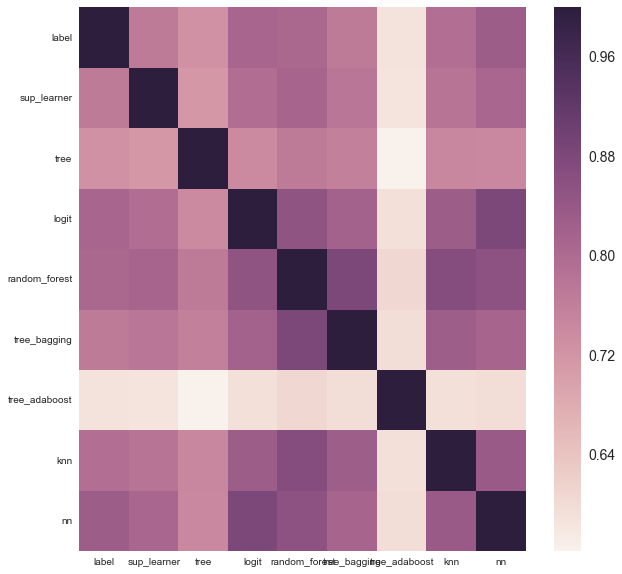

In [27]:
corr = ydf.corr(method='kendall')
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.4)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values , annot_kws={"size": 16}, ax=ax)

<b> Note:</b> Heatmap interpret the correlation between estimators and Super learner nicely. Lable is the ground truth for examples in heatmap.
Each cell in a row has an almost different gradient. That is simply interpreting that models are weakly correlated with each other. Weakly co-related models shown in blue gradient and highly correlated models shown in reddish gradient.
Less correlated models have high diversity and vice versa. 
For the heatmap, I have also compared 7 base estimators with Super Learner and actual ground truth. In overall, estimators show good diversity among each other. 

In [28]:
ydf.corr(method='kendall').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
#plasma inferno magma viridis

In [29]:
tocks = time.time()
mins = (tocks-ticks) / 60
print("time taken to run entire note book is {0:.2f} minutes".format(mins))

time taken to run entire note book is 120.30 minutes
